In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(color_codes=True)

In de algemene populatie is een percentage p besmet met corona. Een willekeurige sample hiervan gaat naar een festival. Vanwege de false-negative rate van een corona self-test, zullen er op een festival met N mensen ongeveer p * N mensen binnen komen met corona.

Naderhand worden er C corona gevallen geconstateerd van de festival bezoekers. Dit zijn dus nieuwe gevallen, aangestoken door de p.N die er binnen kwamen. Binnen ons model zijn dit er dus p.N.R, waar R het aantal mensen is dat een besmet persoon gemiddeld infecteerd.

In het data bestand staan data voor een aantal festivals van grootte N, met de nieuwe gevallen erbij vermeld. Aan de hand van deze data:

bepaal de parameter p ( 0<p<1
bepaal het reproductie getal R (R>0)

Ik heb voorheen over het reproductie getal R geschreven, http://blog.daimonie.com/2020/05/covid19-data-guide-is-r-for-naught_13.html

Ik heb toen als addendum, op aandringen van de "Mad Virologist" (facebook) de R geupdate. Nieuwe inschattingen waren zo hoog als 4.5, en ik zie inderdaad getallen als 6 voorbij komen in een review https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0242128: 
* 2.38-3.44, summary reproductive number
* 5.72-6.99 France
* 5.51-6.69 Germany
 
 Een base reproductive number is "zonder maatregelen" bij vrij mixen. Dat betekent dat het afhangt van je populatie demographics, de manier waarop deze reizen, de population density en een gigantische hoeveelheid aan invloed factoren. Het pure meten hiervan is dus niet altijd ideaal. Ik denk dat 3.5, nadat ik Frankrijk+Duitsland zag, een redelijke aanname is om nu mee te werken.

Ten slot ga ik even een hoop aannames doen:
* Ongeveer 84% van de populatie laat zich vaccineren. Ons gesimuleerde festival heeft dus 84% gevaccineerden.
* Wie gevaccineerd heeft, heeft 95% kans dat het vaccin aangeslagen is (efficacy)
* Wie geaccineerd is, kan de ziekte niet doorgeven ("Herd Immunity" door vaccins).
* Wie covid gehad heeft, kan de ziekte niet doorgeven. 

1,672,744 mensen hebben corona gehad in Nederland (14 Juni, https://www.worldometers.info/coronavirus/country/netherlands/ . Dit is zo'n 10% van de bevolking (meer dan 1% hiervan is overleden, overigens).

Dus, wanneer je iemand tegen komt:
* 84% * 95% kans dat deze immuun is door vaccinatie
* 10% kans dat deze persoon immuun is door ziekte


In [2]:
# these two numbers were extracted 11 June 2021
real_num_corona = 60994
real_population_number = 17280000

real_percentage = real_num_corona / real_population_number
print(f"In the Netherlands, {real_num_corona :.0f} people are estimated to be infected with coronavirus out of {real_population_number: .0f} people ({real_percentage*100: .2f}%).")

real_percentage_spread = real_percentage * 2.0
print(f"Arbitrarily adding a std of {real_percentage_spread: .3f} to that percentage.")


reproductive_number_unfettered = 3.5 # 
reproductive_number_measures = 1.5 # I am just assuming huggy festival people do not follow measures well enough



reproductive_number_vaccins = reproductive_number_unfettered* (1 -0.95 * 0.84) * (1 - 0.1)
reproductive_number_vaccins_measures = reproductive_number_measures* (1 -0.95 * 0.84) * (1 - 0.1)

# This is a reasonable false negative range. Each test has a different one so just an estimation.
false_negative = 0.20

print(f"The rate of false negatives is {false_negative: .3f}.")
print(f"The reproductive number unfettered is {reproductive_number_unfettered: .3f}")
print(f"The reproductive number with measures {reproductive_number_measures: .3f}")
print(f"The reproductive number with vaccins only is {reproductive_number_vaccins: .3f}")
print(f"The reproductive number with vaccins and measures only is {reproductive_number_vaccins_measures: .3f}")

In the Netherlands, 60994 people are estimated to be infected with coronavirus out of  17280000 people ( 0.35%).
Arbitrarily adding a std of  0.007 to that percentage.
The rate of false negatives is  0.200.
The reproductive number unfettered is  3.500
The reproductive number with measures  1.500
The reproductive number with vaccins only is  0.636
The reproductive number with vaccins and measures only is  0.273


In [3]:
def simulate_festival( p=0.01, fn=0.5,  R=5, N=10000, p_std=0.005):

    p_sample = np.abs(np.random.normal(loc=p, scale=p_std, size=1))
    infected_visitors = fn * p_sample * N
    # this is the baseline. They will infect some people. What would a reasonable
    # distribution be?
    # unsure. Wanna do poisson?  lambda = E(X) = VAR(X)
    lambda_param = infected_visitors * R

    # we take one draw out of a poisson distribution, this is the newly infected
    sample = np.random.poisson(
        lam = lambda_param,
        size=1
    )

    return sample

def generate_festivals(
    percentage=0.02,
    percentage_spread=0.01,
    false_negative=0.20,
    reproducive_number=1.2
):
    festival_data = {
        'visitors': np.random.randint(low=10000, high=100000, size=1000),
        'infected': []
    } 

    for N in festival_data.get('visitors'):
            
        infected = simulate_festival(
            p = percentage,
            p_std = percentage_spread,
            fn = false_negative,
            R = reproducive_number,
            N = N
        ) 
        festival_data['infected'].append(infected[0])

    return (
        pd.DataFrame
        .from_dict(festival_data)
    )

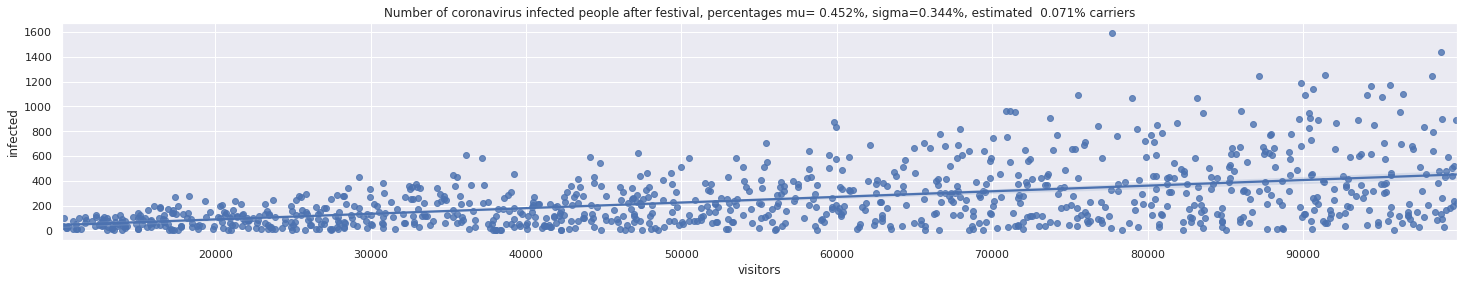

In [4]:

df_festivals = generate_festivals(
    percentage=real_percentage,
    percentage_spread=real_percentage_spread,
    false_negative=false_negative,
    reproducive_number=reproductive_number_unfettered
)

fig, ax = plt.subplots(figsize=(25, 4)) 
sns.regplot(data=df_festivals, x='visitors', y='infected') 

mu = (df_festivals.infected / df_festivals.visitors ).mean()
std = (df_festivals.infected / df_festivals.visitors ).std()
plt.title(f'Number of coronavirus infected people after festival, percentages mu={mu*100: .3f}%, sigma={std*100:.3f}%, estimated {real_percentage*false_negative*100: .3f}% carriers')   
plt.show()

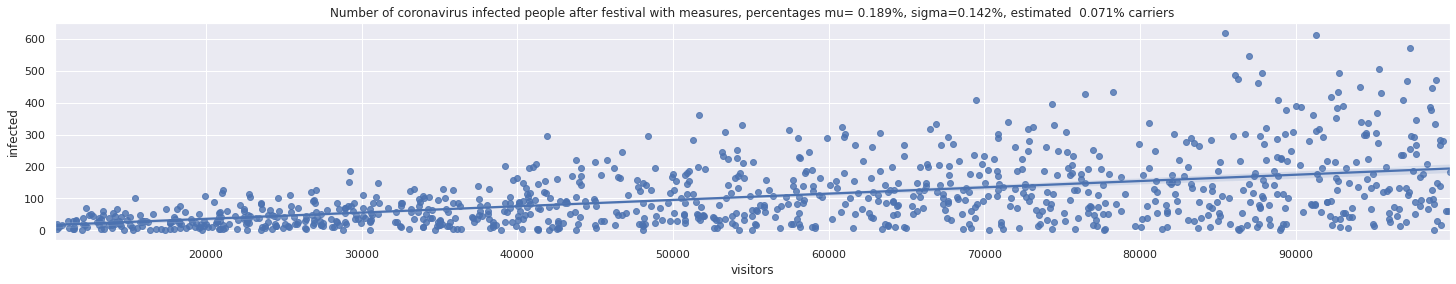

In [5]:

df_festivals_measures = generate_festivals(
    percentage=real_percentage,
    percentage_spread=real_percentage_spread,
    false_negative=false_negative,
    reproducive_number=reproductive_number_measures
)

fig, ax = plt.subplots(figsize=(25, 4)) 
sns.regplot(data=df_festivals_measures, x='visitors', y='infected') 

mu = (df_festivals_measures.infected / df_festivals_measures.visitors ).mean()
std = (df_festivals_measures.infected / df_festivals_measures.visitors ).std()
plt.title(f'Number of coronavirus infected people after festival with measures, percentages mu={mu*100: .3f}%, sigma={std*100:.3f}%, estimated {real_percentage*false_negative*100: .3f}% carriers')  
plt.show()

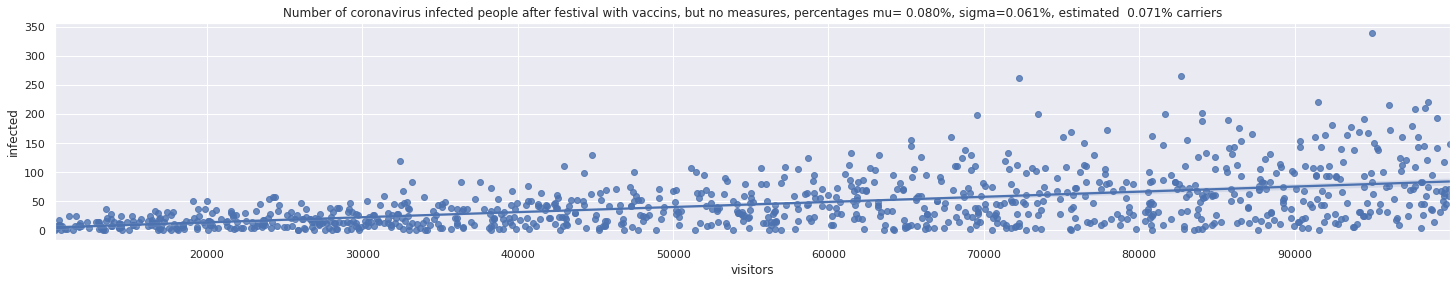

In [6]:

df_festivals_vaccins = generate_festivals(
    percentage=real_percentage,
    percentage_spread=real_percentage_spread,
    false_negative=false_negative,
    reproducive_number=reproductive_number_vaccins
)

fig, ax = plt.subplots(figsize=(25, 4)) 
sns.regplot(data=df_festivals_vaccins, x='visitors', y='infected') 
mu = (df_festivals_vaccins.infected / df_festivals_vaccins.visitors ).mean()
std = (df_festivals_vaccins.infected / df_festivals_vaccins.visitors ).std()
plt.title(f'Number of coronavirus infected people after festival with vaccins, but no measures, percentages mu={mu*100: .3f}%, sigma={std*100:.3f}%, estimated {real_percentage*false_negative*100: .3f}% carriers')  
plt.show()

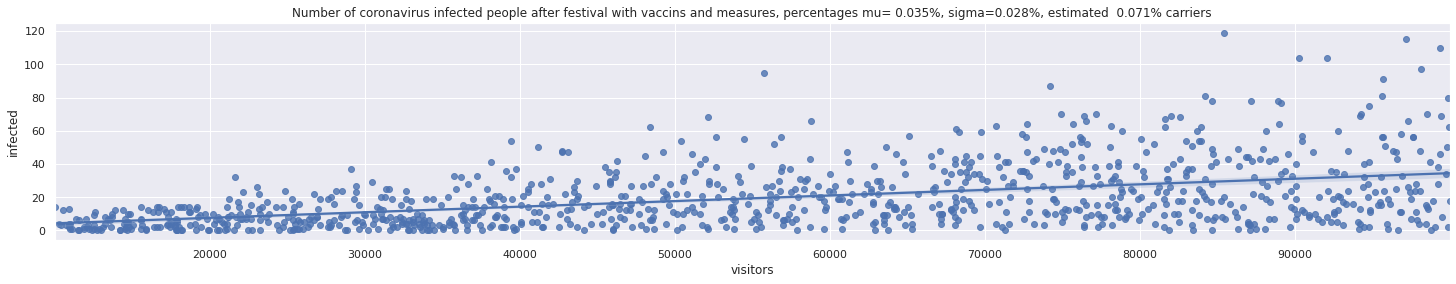

In [7]:

df_festivals_vaccins_measures = generate_festivals(
    percentage=real_percentage,
    percentage_spread=real_percentage_spread,
    false_negative=false_negative,
    reproducive_number=reproductive_number_vaccins_measures
)

fig, ax = plt.subplots(figsize=(25, 4))  

sns.regplot(data=df_festivals_vaccins_measures, x='visitors', y='infected') 
mu = (df_festivals_vaccins_measures.infected / df_festivals_vaccins_measures.visitors ).mean()
std = (df_festivals_vaccins_measures.infected / df_festivals_vaccins_measures.visitors ).std()

plt.title(f'Number of coronavirus infected people after festival with vaccins and measures, percentages mu={mu*100: .3f}%, sigma={std*100:.3f}%, estimated {real_percentage*false_negative*100: .3f}% carriers')  
plt.show()

In [8]:
df_festivals_all = pd.concat([
    df_festivals.assign(situation="unfettered"),
    df_festivals_measures.assign(situation="measures"),
    df_festivals_vaccins.assign(situation="vaccin"), 
    df_festivals_vaccins_measures.assign(situation="vaccin_measures")
])
df_festivals_all.head()

,visitors,infected,situation
0,29986,270,unfettered
1,82294,5,unfettered
2,33497,113,unfettered
3,52333,187,unfettered
4,90148,1096,unfettered


In [9]:
df_festivals_all.to_csv('festival_corona_data.csv')